# 数据分析 - 数据建模(时序模型)

<br>

<img src="https://img.sj33.cn/uploads/202011/7-201109153Z1336.jpg" width = "300" height = "200" alt="图片名称" align=center />

## 目录 - 数据建模(时序模型)

* [0.什么是时序模型](#0.-什么是时序模型)
* [1.时间序列算法](#1.-时间序列算法)
* [2.时间序列的预处理](#2.-时间序列的预处理)
    * [2.1.纯随机性检验](#2.1-纯随机性检验)
    * [2.2.平稳性检验](#2.1-平稳性检验)
         * [2.2.1.平稳时间序列的定义](#2.2.1-平稳时间序列的定义)
         * [2.2.2.平稳性检验方法](#2.2.2-平稳性检验方法)
* [3.平稳时间序列分析模型](#3.-平稳时间序列分析模型)
    * [3.1.AR模型-自回归模型](#3.1-AR模型-自回归模型Autoregressive-model)
    * [3.2.MA模型-自移动模型](#3.2-MA模型)
    * [3.3.ARMA模型-自回归移动平均模型](#3.3-ARMA模型)
* [4.时间序列建模流程](#4.-时间序列建模流程)
    * [4.1.平稳时间序列建模](###-4.1-平稳时间序列建模)
    * [4.2.非平稳时间序列建模流程](###-4.2-非平稳时间序列建模流程)
         * [4.2.1.确定性因素分解的时序分析](#4.2.1-确定性因素分解的时序分析)
         * [4.2.2.随机时序分析](#4.2.2-随机时序分析)
* [5.时间序列建模流程-实战](#5.-时间序列建模流程)
    * [5.1.对时间序列进行平稳性检测](#5.1-对时间序列进行平稳性检测)
    * [5.2.对非平稳的时间序列需要进行差分运算成为平稳的时间序列](#5.2-对非平稳的时间序列需要进行差分运算成为平稳的时间序列)    
    * [5.3.验证平稳的时间序列是否是白噪声序列](#5.3-验证平稳的时间序列是否是白噪声序列)
    * [5.4.ARMA模型建模](#5.4-ARMA-模型建模)


In [1]:
# 在本数据集当中用到的练习数据集是之前的网络流量数据集 - isp.csv
%matplotlib inline
import pandas as pd
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy
import numpy as np
import time
import datetime
import random
import platform
from datetime import datetime
from datetime import timedelta

try:
    data_file = pd.read_csv("../../issue_Documents/data/network_data/isp.csv", header=0, names=["Time","Traffic_Data"])
except FileNotFoundError:
    data_file = pd.read_csv("../issue_Documents/data/network_data/isp.csv", header=0, names=["Time","Traffic_Data"])

data_file

,Time,Traffic_Data
0,19/11/2004 09:30,4838.665376
1,19/11/2004 09:35,4845.176609
2,19/11/2004 09:40,5157.995660
3,19/11/2004 09:45,5637.875537
4,19/11/2004 09:50,5520.689840
...,...,...
19883,27/01/2005 10:25,6515.512337
19884,27/01/2005 10:30,6291.170975
19885,27/01/2005 10:35,6305.518524
19886,27/01/2005 10:40,6422.143533


In [2]:
# 正如之前做到的那样 需要将格式 数据的时间成为标准的时间格式
data_file["Time"] = pd.to_datetime(data_file["Time"], format="%d/%m/%Y %H:%M", errors="raise")
data_file["Traffic_Data"].astype(np.float64)
# data_file["Time"] = data_file["Time"].dt.strftime("%Y-%m-%d %H:%M")
data_file.head(10)

,Time,Traffic_Data
0,2004-11-19 09:30:00,4838.665376
1,2004-11-19 09:35:00,4845.176609
2,2004-11-19 09:40:00,5157.995660
3,2004-11-19 09:45:00,5637.875537
4,2004-11-19 09:50:00,5520.689840
5,2004-11-19 09:55:00,5626.337455
6,2004-11-19 10:00:00,5350.546016
7,2004-11-19 10:05:00,5356.983409
8,2004-11-19 10:10:00,5385.813812
9,2004-11-19 10:15:00,5403.905805


## 0. 什么是时序模型

数据集的相关数据表现形式有很多种，包括但不限于：属性值、数值、标准时间序列等；因此通过数据集的相关时间特征来进行分析，对于常见的拥有标准时间序列的数据集来说非常重要；

所谓的时间序列（时序）是将同一指标的数值按其发生的时间先后顺序排列而成的相关数列；时间序列模型需要做到的对历史数据的分析并利用历史数据对未来进行预测；时间序列建模方法假定历史记录总会自我重演，即使不是完全一样也会非常接近，足以通过研究过去对将来作出更好的决策。

时间序列中的时间可以是年份、季度、月份或者其他的时间形式进行排列的，时间的间隔也多变，其为：分钟、小时、天、月、季度等；

在这里因为涉及到相关的数学算法，因此我们需要设一组随机的变量：$X_1,X_2,\dots,X_t$ 的随机时间的时间序列，注意在这里的相关事件是呈现随机性的；设：$x_1,x_2, \dots , x_n$ 或 ${x_t, t=1,2,3,4,5,\dots,n}$ 表示当前随机序列的 $n$ 个有序观察值，称之为序列长度为 $n$ 的观察序列；

对于时序模型，变化规律有以下四种：
+ 长期变动趋势
+ 季节变动规律
+ 周期变动规律
+ 不规则变动规律

根据不同的影响因素对时间序列变化的不同影响情况，可以分为以下几种影响因素：
+ 长期趋势影响因素
+ 季节变动影响因素
+ 循环变动影响因素
+ 不规则变动影响因素


<br>

参考链接：

+ [如何理解和使用时间序列分析？
](https://zhuanlan.zhihu.com/p/49482623)
+ [IBM-时间序列模型](https://www.ibm.com/docs/zh/spss-modeler/SaaS?topic=nodes-time-series-models)

<br>

### 0.1 模型的评价方法

从这章开始，我们将会接触到一系列的建模方法，也会了解许多的模型的概念，但是，在明确建立如何建立模型之前，必须了解模型的评价方法，常用的最优模型选择有： **AIC** 和 **BIC**


**AIC**

赤池信息量准则（英语：Akaike information criterion，简称AIC）是评估统计模型的复杂度和衡量统计模型“拟合”资料之优良性(Goodness of fit)的一种标准，是由日本统计学家赤池弘次创立和发展的。赤池信息量准则建立在信息熵的概念基础上。

在一般的情况下，AIC可以表示为：

$$
AIC=2k−2ln(L)
$$

其中：

+ k是参数的数量
+ L是似然函数
假设条件是模型的误差服从独立正态分布。让n为观察数，RSS为残差平方和，那么AIC变为：

$$
AIC=2k+nln(RSS/n)
$$

增加自由参数的数目提高了拟合的优良性，AIC鼓励数据拟合的优良性但尽量避免出现过度拟合（Overfitting）的情况。所以优先考虑的模型应是AIC值最小的那一个。赤池信息量准则的方法是寻找可以最好地解释数据但包含最少自由参数的模型。

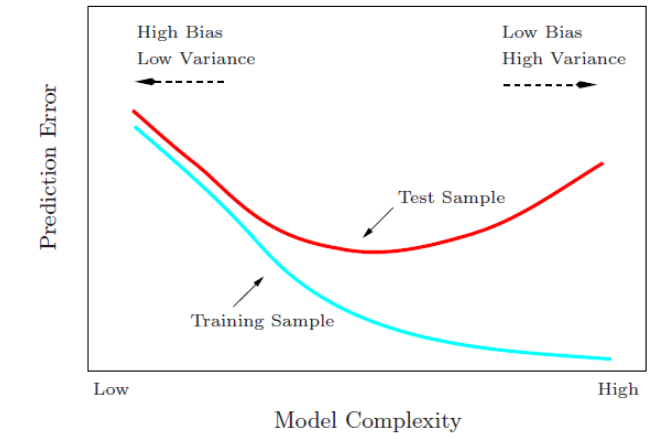


当两个模型之间存在较大差异时，差异主要体现在似然函数项，当似然函数差异不显著时，上式第一项，即模型复杂度则起作用，从而参数个数少的模型是较好的选择。一般而言，当模型复杂度提高（k增大）时，似然函数L也会增大，从而使AIC变小，但是k过大时，似然函数增速减缓，导致AIC增大，模型过于复杂容易造成过拟合现象。AIC不仅要提高模型拟合度（极大似然），而且引入了惩罚项，使模型参数尽可能少，有助于降低过拟合的可能性。



<br>

**BIC**

贝叶斯信息准则，也称为Bayesian Information Criterion（BIC）。贝叶斯决策理论是主观贝叶斯派归纳理论的重要组成部分。是在不完全情报下，对部分未知的状态用主观概率估计，然后用贝叶斯公式对发生概率进行修正，最后再利用期望值和修正概率做出最优决策。公式为：

$$
BIC=ln(n)k–2ln(L)
$$

其中，
 
+ k为模型参数个数
+ n为样本数量
L为似然函数
ln(n)k惩罚项在维数过大且训练样本数据相对较少的情况下，可以有效避免出现维度灾难现象。

与AIC相似，训练模型时，增加参数数量，也就是增加模型复杂度，会增大似然函数，但是也会导致过拟合现象，针对该问题，AIC和BIC均引入了与模型参数个数相关的惩罚项，BIC的惩罚项比AIC的大，考虑了样本数量，样本数量过多时，可有效防止模型精度过高造成的模型复杂度过高。

<br>

**AIC和BIC该如何选择？**

AIC和BIC的原理是不同的，AIC是从预测角度，选择一个好的模型用来预测，BIC是从拟合角度，选择一个对现有数据拟合最好的模型，从贝叶斯因子的解释来讲，就是边际似然最大的那个模型。

共性:

+ 构造这些统计量所遵循的统计思想是一致的，就是在考虑拟合残差的同事，依自变量个数施加“惩罚”。

不同点:

+ BIC的惩罚项比AIC大，考虑了样本个数，样本数量多，可以防止模型精度过高造成的模型复杂度过高。
+ AIC和BIC前半部分是一样的，BIC考虑了样本数量，样本数量过多时，可有效防止模型精度过高造成的模型复杂度过高。

AIC和BIC前半部分是惩罚项，当n≥8n≥8时，kln(n)≥2kkln(n)≥2k，所以，BIC相比AIC在大数据量时对模型参数惩罚得更多，导致BIC更倾向于选择参数少的简单模型。

<br>

参考链接：

+ [最优模型选择准则：AIC和BIC](https://www.biaodianfu.com/aic-bic.html)


## 1. 时间序列算法

<br>



|       算法名称        | 算法描述                                                     |
| :-------------------: | :----------------------------------------------------------- |
|        平滑法         | 平滑法被广泛用于趋势分析和预测，利用修匀技术，削弱短期随机波动对于序列数值的影响，使序列的时间特征更加平滑，根据所用的相关平滑技术不同，具体可以分为：移动平均法和指数平滑法(ES)；<br>参考链接：<br>- [时间序列平滑模型](https://wiki.mbalib.com/wiki/%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97%E5%B9%B3%E6%BB%91%E6%A8%A1%E5%9E%8B)<br>- [指数平滑法](https://wiki.mbalib.com/wiki/%E6%8C%87%E6%95%B0%E5%B9%B3%E6%BB%91%E6%B3%95)<br> |
|      趋势拟合法       | 将时间作为自变量，相应的序列观察值作为因变量，从而建立时间模型。根据序列的相关特征，具体可以分为线性拟合和曲线拟合；<br>参考链接：<br>- [趋势预测法](https://wiki.mbalib.com/wiki/%E8%B6%8B%E5%8A%BF%E9%A2%84%E6%B5%8B%E6%B3%95) |
|       组合模型        | 时间序列的变化主要收到长期趋势($T$)、季节变动($S$)、周期变动($C$)和不规则变动($\epsilon$)的相关影响；<br>计算的相关模型：<br>加法模型：$x_t = Ti+S_i+C_i+\epsilon_i$ <br>乘法模型：$x_t = T_i \times S_i \times C_i \times \epsilon_i$ <br> |
|        AR模型         | 设： 随机变量 $X_t$​ 的 $p$​ 期的序列值：$x_{t-1},x_{t-2},\dots,x_{t-p}$​ 为自变量，设随机变量 $x_t$​ 为因变量来建立相关的先行回归模型；<br>$x_t = \phi_0 + \phi_1x_{t-1} + \phi_2x_{t-2} + \dots + \phi_px_{t-p} + \epsilon_t$​ |
|        MA模型         | 随机变量 $X_t$​​​ 与以前的时间序列的取值无关，建立 $x_t$​​ 与前 $q$​​ 期的随机扰动： $\epsilon_{t-1}, \epsilon_{t-2}, \dots , \epsilon_{t-1}$​<br>$x_t = \mu + \epsilon_t -\theta_1\epsilon_{t-1}-\theta_2\epsilon_{t-2} - \dots \theta_q\epsilon_{t-q}$​ |
|       ARMA模型        | 随机变量 $X_t$​​ 的值 $x_t$​​ 不仅与以前的时间序列 $p$​​ 的取值相关，并与前 $q$​​ 期的随机扰动相关；<br>$x_t = \phi_0 + \phi_1x_{t-1} + \phi_2x_{t-2} + \dots + \phi_px_{t-p} + \epsilon_t -\theta_1\epsilon_{t-1}-\theta_2\epsilon_{t-2} - \dots \theta_q\epsilon_{t-q}$​ |
|       ARIMA模型       | 许多非平稳序列进行差分之后会显示出平稳序列的性质，称这个非平稳序列为差分平稳序列；<br>参考链接：<br> - [ARIMA模型](https://zh.wikipedia.org/wiki/ARIMA%E6%A8%A1%E5%9E%8B)<br>- [ARIMA 模型 - 知乎](https://zhuanlan.zhihu.com/p/60648709) |
|       ARCH模型        | ARCH模型能准确地模拟时间序列变量的波动性变化，适用于序列具有异方差性并且异方差函数短期特征自相关；<br> - [时间序列 \| ARCH 模型](https://zhuanlan.zhihu.com/p/128796473) |
| GARCH模型及其衍生模型 | GARCH模型称为广义ARCH模型，是ARCH模型的拓展；相比于ARCH模型，GARCH模型及其衍生模型更能反映实际序列中的长期记忆性、信息非对称性；<br> - [MBA智库 - GARCH 模型](https://wiki.mbalib.com/wiki/GARCH%E6%A8%A1%E5%9E%8B) |



<br>

## 2. 时间序列的预处理

拿到一个相关的数据集之后， 根据前边的相关知识我们知道需要对数据进行预处理，对于时序性数据的预处理和之前的数据的预处理方法不是相同；

对于时序数据的处理， 我们需要对数据集进行：
+ 纯随机性检验
+ 平稳性检验

对于时间序列进行检验之后，根据检验结果将序列分为不同的类型，对不同的类型序列会采用不同的分析方法；

### 2.1 纯随机性检验

纯随机性检测也被称为白噪声检测，一般是构造检验统计量来检验序列的纯随机性；

纯随机序列又被称为“**白噪声序列**”，所谓的“白噪声”代表的含义是：对所有时间其自相关系数为零的相关特性，即序列中各项之间是没有任何关系的，序列在进行完全无序的随机波动，对于白噪声相关的数据集，我们期望其自相关值接近于0；白噪声是没有信息提取的平稳序列；

如果一个序列是纯随机序列，那么它的序列值之间就没有任何关系，设满足关系 $\gamma(k)=0, k \neq C$，就是一种理论上出现的理想状态，实际上纯随机序列的样本自相关系数不会绝对为零，会在零附近随机波动；

如何证明当前的数据特性是纯随机序列？

+ ACF 法：
    + 对于白噪声的边界问题，设一个长度为 $T$ 的白噪声序列，期望在0.95的置信区间之内，其自相关值处于：$\pm{\frac{2}{\sqrt{T}}}$ 之间，可以很快画出其边界值，如果在一个时间序列中有较多的自相关值在边界之外，那么这个时间序列可能就不是白噪声序列；
+ LBQ 统计量：
    + Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。

参考链接：

+ [什么是 LBQ 检验？](https://www.zhihu.com/question/22863169)
+ [白噪声](https://otexts.com/fppcn/wn.html)

<br>

### 2.2 平稳性检验

对于平稳的非白噪声序列，其方差和均值都是常熟，通常对于平稳的非白噪声序列，一般通过构造线性模型来模拟该序列的发展，用于提取有用的相关信息；

对于非平稳的白噪声序列，其均值和方差都是不稳定，处理方法一般是将其转变为平稳序列，这样就可以应用有关平稳时间序列的分析方法；

如果一个时间序列经过差分运算后具有平稳性，那么称该序列为：差分平稳序列；

在这里，我们必须明确相关的平稳序列概念；

#### 2.2.1 平稳时间序列的定义

对于一个随机变量 $X$，可以计算相关的均值$\mu$、数学期望$\sigma^2$，对于两个随机变量可以计算其协方差($cov(X,Y)$)以及相关系数($\rho(X,Y)$)，相关系数度量了两个变量之间的相互影响的，计算公式如下：

$$
cov(X,Y) = E[(X-\mu_x)(Y-\mu_y)] \quad E\;是求其平均值
\\
\rho(X,Y) = \frac{cov(X,Y)}{\sigma_x \sigma_y}
$$

当然上边的都是针对一般的数据集，两个数值属性之间的相关计算；

对于时间序列的相关函数，就和普通的数据集就不要太一样了，因此需要区分进行对待；

对于一个时间序列，我们设为： ${X,t \in T}$，则在任意时刻的的序列值 $X_t$ 都是一个随机变量，每一个随机变量都会有对应的均值和方差，记任意时刻的序列值 $X_t$ 的均值为 $\mu_t$，其方差为 $\sigma_t$；

任取一个 ${t,s}$，对于上边参数解释是： $t$ 是一个时刻点，$s$是一个区别于 $t$ 的时刻点，从原则上来解释，那么 $s$ 的时刻点比 $t$ 更考后，${t,s}$代表的是一个时间段；

我们定义这个时间段的**自协方差函数**为 $\gamma(t,s)$，其计算公式如下：

$$
\gamma(t,s) = E[(X_t - \mu_t)(Y_s - \mu_s)] \quad \gamma(t,t) = \gamma(0) = 1
$$

定义这个时间段的 **自相关系数** $\rho(t,s)$，其计算公式如下：

$$
\rho(t,s) = \frac{cov(X_t,X_s)}{\sigma_t \sigma_s} \quad \rho_0 = 1
$$

在上边的<自协方差函数>和<自相关系数>都是描述同一个事件在不同时间点(${t,s}$)之间的相关程度，通俗来说，就是度量事件过去对将来的影响；

参考方差的计算方式：

$$
\begin{equation}
\rho_{X,Y} = corr(X,Y) = \frac{cov(X,Y)}{\sigma_X\sigma_Y} =\frac{\frac{\sum_{i=1}^n{(X_i-\overline{X})(Y_i-\overline{Y})}}{n-1}}{\sqrt{\frac{\sum_{i=1}^n(X_i-\overline{X})^2}{n-1}}\sqrt{\frac{\sum_{i=1}^n(Y_i-\overline{Y})^2}{n-1}}}
= \frac{\sum_{i=1}^n{(X_i-\overline{X})(Y_i-\overline{Y})}}{\sqrt{\sum_{i=1}^n(X_i-\overline{X})^2\sum_{i=1}^n(Y_i-\overline{Y})^2}}
\end{equation}
$$

<br>
从公式的定义上来看，对于上边的自相关系数，则越接近1则相关度越高；

<br>

如果时间序列 ${X_t,t \in T}$ 在某一常数附近波动且波动范围有限，即该时间序列事件拥有常数均值和常数方差，并且延迟 $k$ 期的序列变量的自协作方差和自相关系数与之前时间节点相等；
则称为该时间序列 ${X_t, t \in T}$ 为平稳序列；

<br>

#### 2.2.2 平稳性检验方法

对于常用的平稳性检测的方法：

+ 时序图和自相关图的特征呕出相关的判断，操作简单，但是带有主观性；
+ 构造相关检验统计量方法，目前最常用的方法是：单位根检验；

**1)时序图检验**

因为平稳时间序列存在均值和方差都为常数，因此相关时序图的显示该序列的值在一个常数附近随机波动，并且波动的范围有界，如果表现出明显的趋势性或者周期性，那么就是不是平稳序列；

**2)自相关图检验**

平稳序列具有短期相关性，对于平稳序列而言通常只有近期的序列值对现时值的影响比较明显，对于一个间隔较远的过去对现时值得影响较小；

+ 因此对于一个平稳的时间序列，随着延迟期数 $k$ 的增加，那么自相关系数 $\rho_k$ 就会很快趋近于零，并在零值附近波动；

+ 对于一个非平稳序列的自相关系数衰减的速度会比较慢；

上述两点可以作为利用自相关图来衡量相关事件序列是否是平稳序列的依据；

**3)单位根检验**

求出时间序列的单位根，如果存在单位根就是非平稳时间序列；

<br>

参考链接：

+ [自相关acf/偏自相关pacf图分析](https://spssau.com/helps/conometricstudy/acfpacf.html)
+ [截尾/拖尾的问题解释](https://www.zhihu.com/question/373433479)

In [3]:
# Python 当中提供了相关的工具来计算相关系数
# Tushare 是一个免费提供金融数据的平台，使用 API 来获取 JSON 数据完成对应
# statsmodels 提供了相关的工具来计算自相关性
if platform.system().lower() == "windows":
    ! pip install tushare statsmodels --upgrade
else:
    !{sys.executable} -m pip install tushare statsmodels --upgrade

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [4]:
import tushare as ts
from statsmodels.tsa import stattools
# 从 Tushart 导入 Data
# 注意你需要在 Tushare 注册一个新的账号，根据下方的链接:
# https://waditu.com/document/1?doc_id=131
ts_api = ts.pro_api('43a338486287adb596b397b2a4291b1b08f61d524c4f8517a8624a5f')

# 获取数据
df_tushare = ts_api.daily(ts_code='000001.SZ', start_date='20180701', end_date='20181031')
df_tushare

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20181031,10.95,10.99,10.75,10.91,10.90,0.01,0.0917,1152683.79,1252156.775
1,000001.SZ,20181030,10.78,11.08,10.73,10.90,10.75,0.15,1.3953,1501827.86,1641371.787
2,000001.SZ,20181029,11.20,11.24,10.62,10.75,11.18,-0.43,-3.8462,1591628.78,1725932.497
3,000001.SZ,20181026,11.29,11.31,10.96,11.18,11.29,-0.11,-0.9743,1299975.10,1448843.512
4,000001.SZ,20181025,10.80,11.29,10.71,11.29,11.04,0.25,2.2645,1685011.36,1855823.739
...,...,...,...,...,...,...,...,...,...,...,...
77,000001.SZ,20180706,8.61,8.78,8.45,8.66,8.60,0.06,0.7000,988282.69,852071.526
78,000001.SZ,20180705,8.62,8.73,8.55,8.60,8.61,-0.01,-0.1200,835768.77,722169.579
79,000001.SZ,20180704,8.63,8.75,8.61,8.61,8.67,-0.06,-0.6900,711153.37,617278.559
80,000001.SZ,20180703,8.69,8.70,8.45,8.67,8.61,0.06,0.7000,1274838.57,1096657.033


<IPython.core.display.Javascript object>


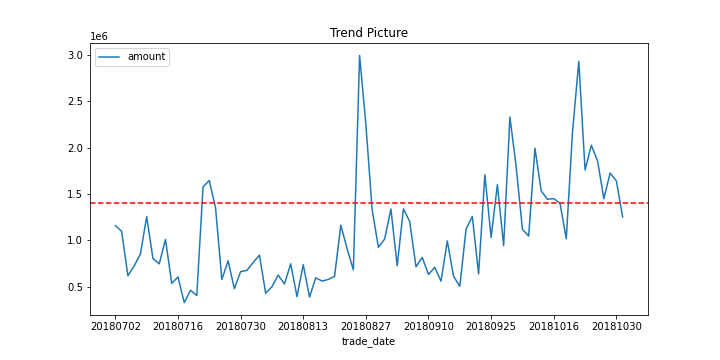

In [5]:
# 数据的相关数值的特性不容易在非图形展示中比较，因此需要使用
%matplotlib notebook
plt.rcParams['axes.unicode_minus'] = False
ax = df_tushare[["trade_date", "amount"]].sort_index(ascending=False).plot(x="trade_date",figsize=(10,5))
# 我们可以看到整体的趋势来说，交易总量在 1.4*1000000 的上下移动，但是也存在极值的问题
ax.set_title("Trend Picture")
ax.axhline(y=1.4*(10**6), color='r', linestyle='--')

<IPython.core.display.Javascript object>


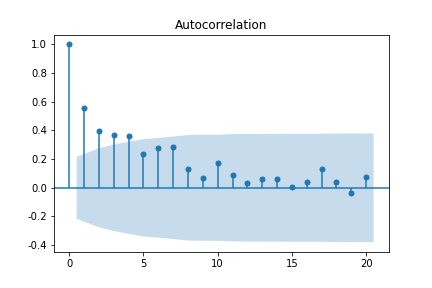

In [6]:
# 打印自相关图 - 自相关系数图
# statsmodels 已经提供了相关的模块，来打印 ACF 相关系数
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 需要改变一下数据结构，将选中的数据变成 n*1 的数据结构
# 即将时间列进行转换：
df_acf = df_tushare[["trade_date", "amount"]]
df_acf = df_acf.set_index("trade_date")
plot_acf(df_acf).show()
# 对下边的自相关图进行分析：
#   1.下边的图片中，可以看到到最后图像并不趋近于0而是出现了在0值上下，因此属于拖尾现象；
#   2.从1阶之后出现了截尾现象；

<IPython.core.display.Javascript object>


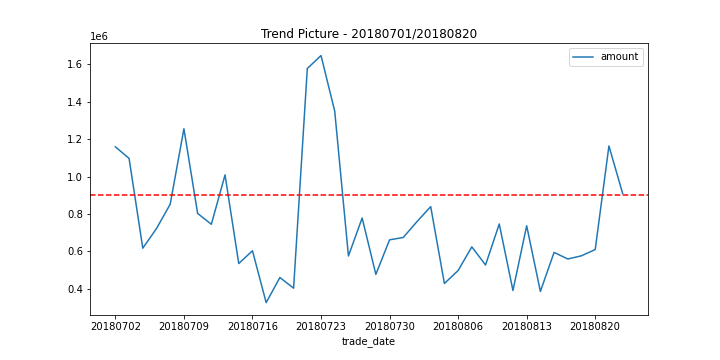

<IPython.core.display.Javascript object>


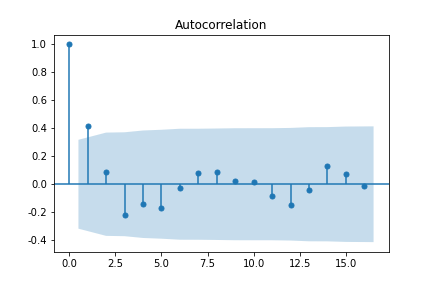

In [7]:
# 我们在这里可以尝试打印从 20180701 - 20180831 日期的
# 
df_tushare_1 = ts_api.daily(ts_code='000001.SZ', start_date='20180701', end_date='20180822')
ax = df_tushare_1[["trade_date", "amount"]].sort_index(ascending=False).plot(x="trade_date",figsize=(10,5))
# 我们可以看到整体的趋势来说，交易总量在 0.9*1000000 的上下移动，但是也存在极值的问题
ax.set_title("Trend Picture - 20180701/20180820")
ax.axhline(y=0.9*(10**6), color='r', linestyle='--')
plot_acf(df_tushare_1[["trade_date", "amount"]].set_index("trade_date")).show()

<IPython.core.display.Javascript object>


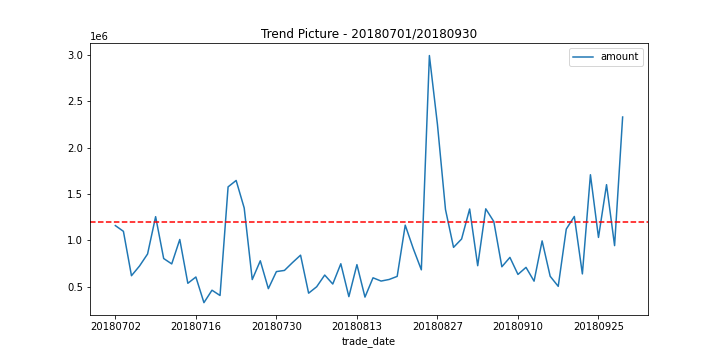

<IPython.core.display.Javascript object>


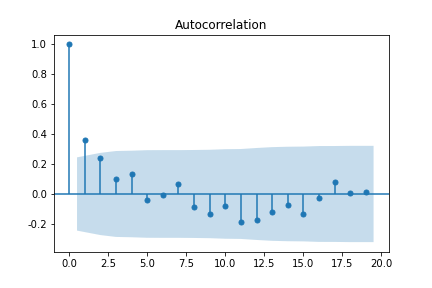

In [8]:
# 我们在这里可以尝试打印从 20180701 - 20180930 日期的
# 
df_tushare_2 = ts_api.daily(ts_code='000001.SZ', start_date='20180701', end_date='20180930')
ax = df_tushare_2[["trade_date", "amount"]].sort_index(ascending=False).plot(x="trade_date",figsize=(10,5))
# 我们可以看到整体的趋势来说，交易总量在 0.9*1000000 的上下移动，但是也存在极值的问题
ax.set_title("Trend Picture - 20180701/20180930")
ax.axhline(y=1.2*(10**6), color='r', linestyle='--')
plot_acf(df_tushare_2[["trade_date", "amount"]].set_index("trade_date")).show()

<br>

**从上边的的图片分析，可以总结以下的几个在时序分析时需要注意的几个点**：

+ 不同长度时间长度的时序数据集所呈现出来的拖尾、截尾的现象不同，即在相同数据集不同时间长度展示的相关数据特征也不同；
+ 在进行时序分析时，需要尝试不同的时间维度和时间跨度来构建相关的时序模型；



In [9]:
# 我们尝试计算一下自相关系数
# API为：https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html
stattools.acf(df_tushare.pct_chg, nlags=15, fft=False)
# 参考对于自相关图的评价标准，相关系数呈现的是快速下降并在零值周围进行随机波动，因此

array([ 1.        , -0.06484837, -0.09008953,  0.1387848 , -0.09847929,
       -0.06146479, -0.07771078, -0.02068644, -0.21413236, -0.09274319,
       -0.02341678,  0.04484859,  0.07904406, -0.07009267,  0.01649576,
       -0.026699  ])

In [10]:
# 也可以得到偏移自相关技术
stattools.pacf(df_tushare.pct_chg, nlags=10)
# 可以看出现在数据呈现出拖尾的情况

array([ 1.        , -0.06564897, -0.09706991,  0.13285093, -0.09739978,
       -0.05320687, -0.13243133, -0.01921874, -0.27068037, -0.14064752,
       -0.14833933])

## 3. 平稳时间序列分析模型


自回归移动平均模型 (Autoreg Ressive Moving Average Model) 是目前最常用的拟合平稳模型了，根据数据集的相关趋势特征（截尾、拖尾等），又可以被细分为 AR模型、MA模型、ARMA模型三大类，都可以被认为是多元线性回归模型；

拖尾、截尾特征如下：

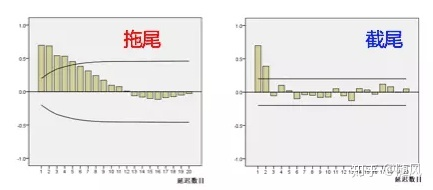


### 3.1 AR模型-自回归模型Autoregressive model

在之前的表格当中，我们知道了`AR模型`的相关代数表示，即如下：

$$
\begin{equation}
x_t = \phi_0 + \phi_1x_{t-1} + \phi_2x_{t-2} + \dots + \phi_px_{t-p} + \epsilon_t \\
\end{equation}
$$

其中，设$t$ 的值是某一个将来的时刻，则随机变量$X_t$的相关取值 $x_t$ 是由**前 $p$ 期** $x_{t-1},x_{t-2},\dots,x_{t-p}$ 的多元线性回归，即假设 $x_t$ 是受到前 $p$ 个时期的影响，在上边的公式中我们假设存在一个误差项，作为随机干扰 $\epsilon_t$ ，为零均值白噪声序列；

对于 AR 模型的相关性质如下：

+ 平稳 AR 模型的相关性质
    + 均值： 常数均值
    + 方差： 常数方差
    + 自相关系数ACF：拖尾
    + 偏自相关系数： $p$ 阶截尾；

<br>

对于上边性质的数学分析：

1) 均值

满足平稳性条件的方程：

$$
E(x_t) = E(\rho_0 + \rho_1x_{t-1} + \dots + \rho_px_{t-p}) \\
$$

已知 $E(x_t)=\mu, E(\rho_t) = 0$

即可知道满足上式的均值 $\mu$：

$$
\mu = \frac{\rho_0}{1-\rho_1-\rho_2-\dots-\rho_p}
$$

2) 方差 - 常数

3) ACF 自相关系数

因为定义 AR 模型的相关数据特征，存在指数的衰减，我们都知道指数衰减的特征如下：

始终存在非零取值，不存在 $k$ 大于某个常数值后所有的自相关系数就为零，这就代表着平稳$AR(p)$ 模型的自相关系数 $\mu_k$ 具有拖尾性；

指数衰减的特征如下图所示：

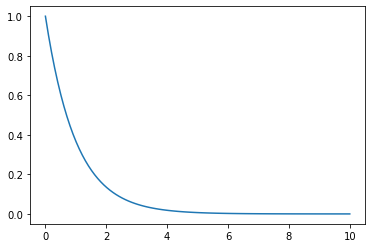

4) 偏自相关技术

因为时间序列是存在一段时间的相关数据，我们在之前设 $t$ 作为一个需要预测的时间点，因为此对于一个之前的时间点 $s$，AR模型并不是单独描述两个时间点 $k$ 与 $s$ 之间的关系，而是 $s$ 与 $t$ 之间的所有时间点的数据都会影响；

经过证明 $AR(p)$ 的偏自相关系数具有 $p$ 阶截尾性；

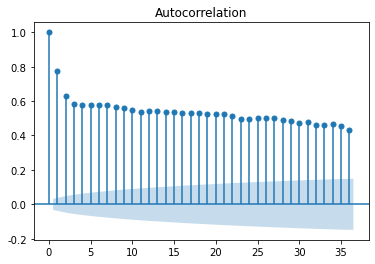

<br>

### 3.2 MA模型

根据之前表格我们知道下边的计算公式：

$$
\begin{equation}
x_t = \mu + \epsilon_t -\theta_1\epsilon_{t-1}-\theta_2\epsilon_{t-2} - \dots \theta_q\epsilon_{t-q}
\end{equation}
$$

对上边公式的说明：即在 $t$ 时刻的随机变量的 $X_t$ 的取值 $x_t$ 受到前 $q$ 期的随机扰动（这里需要和上边AR的 $p$ 区分） $\epsilon_{t-1},\epsilon_{t-2},\dots,\epsilon_{t-q}$的多元线性方程组；

其中，误差项是当期的随机干扰 $\epsilon_t$，设为零均值白噪声序列，$\mu$ 是序列 ${X_t}$的均值。

认为 $x_t$ 主要是受到过去的影响；

相关性质参照下方：

+ 均值： 常数均值；
+ 方差： 常数方差；
+ 自相关系数(ACF)： $q$ 阶截尾
+ 偏自相关系(PACF)： 拖尾

<br>

### 3.3 ARMA模型

ARMA模型（自回归移动模型），简记为 `ARMA(p,q)`；

根据上边表格，定义该模型的代数定义为：

$$
x_t = \phi_0 + \phi_1x_{t-1} + \phi_2x_{t-2} + \dots + \phi_px_{t-p} + \epsilon_t -\theta_1\epsilon_{t-1}-\theta_2\epsilon_{t-2} - \dots \theta_q\epsilon_{t-q}
$$

对于上边的相关定义，在 $t$ 时刻的随机变量 $X_t$ 的取值是 $x_t$ 受到前 $p$ 期 $x_{t-1},x_{t-2},\dots,x_{t-q}$ 和 前 $q$ 期的误差项 $\epsilon_{t-1},\epsilon_{t-2},\dots,\epsilon_{t-q}$ 的共同影响；

其中随机扰动是 $\epsilon_{t}$;

需要注意的是，在 $q$ 等于零时，该模型变成：`AR(p)`自回归模型，在 $p$ 等于零时，该模型是 `MA(q)` 移动平均模型；

该模型的特征是：

+ 均值： 常数均值
+ 方差： 常数方差
+ 自相关系数： $p$ 阶拖尾
+ 偏自相关系数： $q$ 阶拖尾


## 4. 时间序列建模流程

并不是所有的时间序列都是平稳的非白噪声序列，对于大多数时间序列来说，都是非平稳的时间序列，因此在建模之前需要对


### 4.1 平稳时间序列建模

对于平稳时间序列，可以直接使用 ARMA 模型进行建模，对于一个时间序列 $X$，可以直接计算出来 自相关系数 和 偏自相关系数，根据这两个相关系数的性质选择模型进行拟合；

平稳时间的建模流程如下：

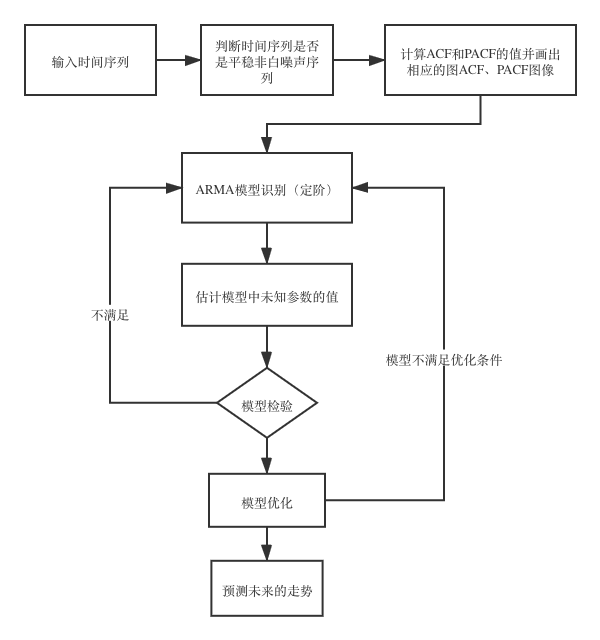

**流程如下**:

1) 计算 ACF 和 PACF 的数值；

2) ARMA 模型识别，模型定阶， 根据上述 AR模型、MA模型、ARMA模型的ACF图、PACF图的相关拖尾、截尾性质选取对应的模型；

+ $AR(p)$：
    + 自相关系数 ACF： 拖尾
    + 偏自相关系数 PACF： $p$ 阶截尾
+ $MA(q)$：
    + 自相关系数 ACF： $q$ 阶截尾
    + 偏自相关系数 PACF： 拖尾
+ $ARMA(p,q)$：
    + 自相关系数 ACF： $q$ 阶截尾
    + 偏自相关系数 PACF： $p$ 阶截尾

3) 未知参数进行校验

4) 模型检验、模型优化

5) 模型的短期预测

<br>


### 4.2 非平稳时间序列建模流程

非平稳时间序列的分析方法可以分为**确定性因素分解的时序分析**和 **随机时序分析**；

#### 4.2.1 确定性因素分解的时序分析

确定性因素分解的时序分析将变化的因素分为了四大类：

+ 长期趋势
+ 季节变动
+ 循环变动
+ 随机波动

随机变动非常难以进行分析，并且对于信息的浪费也比较严重，因此会存在模型拟合的精度不够理想；

#### 4.2.2 随机时序分析

随机时序分析法的发展就是为了弥补确定性因素分解法的额不足，根据时间序列的不同特点，有以下几个模型的方法：

+ ARIMA 模型 - (差分运算+ARNA建模流程)
+ 异方差模型
+ 残差自回归模型
+ 季节模型

对于随机时序分析的相关流程如下：

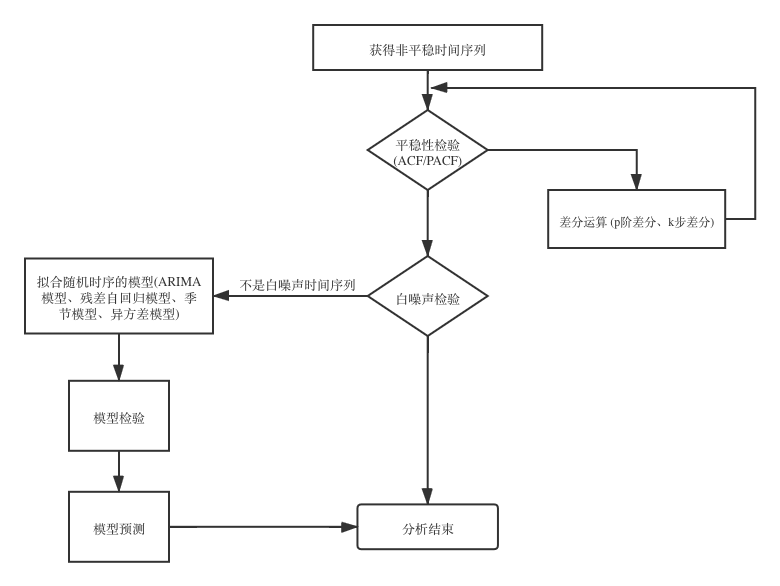

**1.差分运算**

+ $p$ 阶差分
    + 相距一期的两个序列值之间的减法运算被称为： 1阶差分运算
+ $k$ 步差分
    + 相距$k$期的两个序列值之间的减法运算被称为： $k$ 步差分运算
    
经过查分之后的时间序列会呈现出平稳序列的性质，因此被成为成为：差分平稳序列；

**差分平稳序列** 可以通过 **ARMA 模型** 进行建模拟合；

<br>


---

## 5. 时间序列建模流程


### 5.1 对时间序列进行平稳性检测

**对上边的ADF值进行相关分析 - 时间序列的平稳性检测**

在 statsmodel 提供了相关的API：https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html


返回值的顺序依次是：

+ adf 值： 测试统计值
+ pvalue： 基于MacKinnon的近似 $p$ 值
+ uselag： 滞后数量
+ nobs： 用于ADF回归的观察数和临界值计算
+ critical value: 测试统计数据的临界值
+ lcbest： 最大化信息标准
+ resstore： 虚拟类，结果作为属性相加

对于ADF值判断的标准是：

+ 对ADF值进行判断的依据是：对于 1%、5%、10%不同程度拒绝原假设的统计值和ADF Test result的值进行比较，如果 ADF Test result 同时小于 1%、5%、10% 的值，那么就说明该序列很好地拒绝平稳性假设，该序列是平稳的；

<br>


---

In [11]:
# 我们以上边 df_tushare 选取 20180701-20180931 时间段中的 "amount" 数据
# 对于一个时序模型来说首先要进行平稳性检测 - 计算单位根
from statsmodels.tsa.stattools import adfuller

# 尝试进行平稳性检测
df_amount = df_tushare[["trade_date","amount"]]
adfuller(df_amount["amount"])

# 从上边的数据中，我们已经得到:
# adf值为：-4.753823274639612, '1%': -3.5137900174243235, '5%': -2.8979433868293945,'10%': -2.5861907285474777 adf 是小于三个假设临界值，因此我们认为目前这个序列是平稳的；

(-4.753823274639612,
 6.659738326847642e-05,
 0,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 1997.4937490938353)

In [12]:
df_amount_1 = df_tushare_1[["trade_date","amount"]].copy()
df_amount_2 = df_tushare_2[["trade_date","amount"]].copy()

---
**练习**
$\textsf{TODO - 1.1:}$

+ 1.在上边的我们知道了 df_tushare 中 "amount" 的时间序列变化值是平稳的，在上边的代码中对于 PCA图 选取不同的时间跨度数据进行绘制，从上边的绘制图片我们大体上可以猜到目前的是时间序列是否稳定，我们为了；
    + 之前我们就已经声明了变量：`df_tushare_1` 和 `df_tushare_2`，请模仿上边的步骤，算出对应数据变量的ADF值；
    + 并评价对应数据的ADF值，判断是否满足平稳性要求；

<br>

---

In [13]:
# 计算 df_tushare_1 的 adf值


(-3.6185547612186846,
 0.00541604928918952,
 0,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 762.8363981319073)

In [14]:
# 计算 df_tushare_2 的 adf值


(-5.792076774135881,
 4.846106391679185e-07,
 0,
 63,
 {'1%': -3.5386953618719676,
  '5%': -2.9086446751210775,
  '10%': -2.591896782564878},
 1498.0708716717393)


### 5.2 对非平稳的时间序列需要进行差分运算成为平稳的时间序列

Pandas 提供了差分运算的运算函数：**pandas.DataFrame.diff()**


API链接：[pandas.DataFrame.diff - API](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html)

对于差分运算的解释如下：

对于 $1 \times n$ 的数组来说，设该数组为： $X$， 对于计算一阶差分的公式如下：

<br>

$$
\begin{equation}
X = 
    \begin{bmatrix}
        x_1 \\
        x_2 \\
        x_3 \\
        x_4 \\
        \dots \\
        x_n \\
     \end{bmatrix}
\end{equation}
$$
<br>
<br>
<br>

$$
\begin{equation}
diff_1(X) =     
    \begin{bmatrix}
        NaN \\
        x_2 - x_1 \\
        x_3 - x_2 \\
        x_4 - x_3 \\
        \dots \\
        x_n - x_{n-1} \\
    \end{bmatrix}
\end{equation}
$$

同理，2阶差分的计算公式如下：
$$
\begin{equation}
diff_2(X) =     
    \begin{bmatrix}
        NaN \\
        NaN\\
        x_3 - x_1 \\
        x_4 - x_2 \\
        \dots \\
        x_n - x_{n-2} \\
    \end{bmatrix}
\end{equation}
$$

<br>



<IPython.core.display.Javascript object>


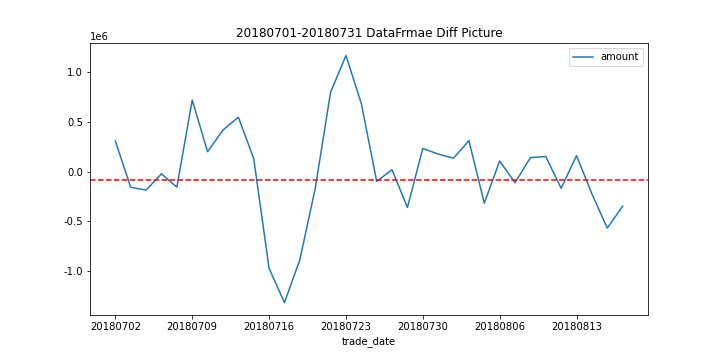

In [15]:
# 通过上边的公式，我们可以知道 df_amount_1 的时间序列是不平稳的
# 通过对 ARIMA 模型的流程了解，我们对非平稳时间序列进行差分处理之后变成平稳时序序列之后再放入到ARMA模型中处理；
# 对 df_amount_1 进行差分处理
# 结果如下：
df_amount_diff = df_amount_1["amount"].diff(periods=4).dropna().to_frame()
df_amount_diff["trade_date"] = df_tushare_1["trade_date"]
# 光看数据不是非常直观，我们需要对所有的数据进行可视化处理
ax = df_amount_diff.sort_index(ascending=False).plot(x="trade_date",figsize=(10,5))
ax.set_title("20180701-20180731 DataFrmae Diff Picture")
ax.axhline(y=-0.08*(10**6), color='r', linestyle='--')
# 可以看到经过差分的数据呈现出较为靠近 -0.08*10^6 之间来回摆动

In [16]:
# 现在我们重新来尝试对进行差分序列之后的数据求出 ADF 值
adfuller(df_amount_diff["amount"])
# 经过差分之后，对下边的值我们发现呈现如下的特点：
# - 经过差分处理之后 adf 的值明显降低了
# - 经过差分之后 adf 的值 明显小于 1%/5%/10%，因此是一个平稳序列

(-4.838825445722927,
 4.58099358132418e-05,
 2,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 661.6736824768525)

<IPython.core.display.Javascript object>


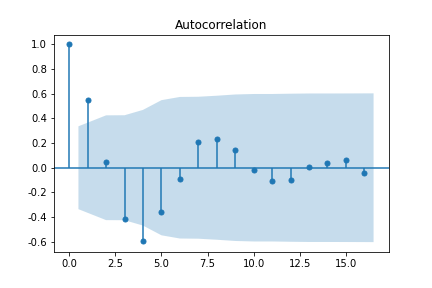

<IPython.core.display.Javascript object>


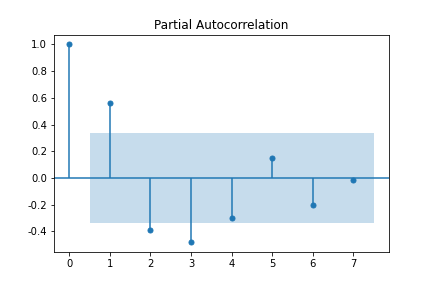

In [17]:
# 打印一下自相关图 和 偏自相关图
plot_acf(df_amount_diff[["trade_date", "amount"]].set_index("trade_date")).show()
plot_pacf(df_amount_diff[["trade_date", "amount"]].set_index("trade_date"), lags=7).show()

<br>

### 5.3 验证平稳的时间序列是否是白噪声序列

在验证了时间序列是平稳序列之后，现在需要检验该平稳时间序列**是不是白噪声序列**

`statsmodels` 提供了相关的工具来检验是否是白噪声序列；

`statsmodels.stats.diagnostic.acorr_ljungbox` 可以计算统计量和相关 $p$ 值；

上述API的官方文档链接：[acorr_ljungbox API](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)         

对于检验统计量和 $p$ 值得判定和评价标准：

+ 由样本各延迟期数的自相关系数可以计算得到检验统计量，然后计算对应的 $p$ 值，如果 $p$ 值显著大于显著性水平 $\alpha$ ，则表示该序列不能拒绝纯随机的原假设，可以停止对该序列的分析。
    + 对于 $p$ 值，$p \geq 0.05$ 则判定该存在随机性，即是一个纯随机序列，这就是进行白噪声监测的标准；
    + 此外，白噪声可以帮助发掘剩余时间序列的信息价值；


<br>


In [18]:
# 接下来进行白噪声监测
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df_amount_diff["amount"], lags=1, return_df=True)

# 我们可以发现经过 4步差分之后的序列的 p 值小于<0.05>，因此假设该时间序列为纯随机序列的概率较低，因此不是白噪声序列

,lb_stat,lb_pvalue
1,11.109653,0.000859



### 5.4 ARMA 模型建模

建模的相关参考标准和相关系数图标准，在前边就已经进行了相关讲解，请参考：[3.平稳时间序列分析模型](#3.-平稳时间序列分析模型)

`statsmodels` 提供了 ARIMA 模型可以进行调用，具体的API请参考链接：[statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

在这里讲解一下完成平稳性检测和白噪声检测之后，建模的相关主要流程：

1) 对于模型的阶数一般不超过数据总长度的10分之一；

2) 选择 $p$ 和 $q$ 的值，使用 BIC 模型来进行拟合和求出误差值；

3) 最后选取最小误差的 $p$ 和 $q$ 值；

<br>

在这里，挑选建模的模型阶数需要注意以下几点：

+ 对于数据的时间序列需要呈现出连续性，对于不是连续性的时间序列使用 ARIMA 建模时会存在 `A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.' forecasting.', ValueWarning)` 的报错；

+ 建模时候需要对选取的阶数进行选取判断，使用 BIC 法求出 BIC 值，选取 BIC 中最小值对应的 $p$, $q$ ，并进行建模；

+ 对于特殊的时间序列需要用 `to_period` 函数进行处理，这里举几个例子：对于在工作日才有的数据，需要使用 `B` 参数进行处理，详细的处理链接请参考: [to_peiod-offset参数](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases)


In [19]:
# 对上边的数据 - df_amount_diff 继续建模
from statsmodels.tsa.arima.model import ARIMA

df_amount_1 = df_tushare_1[["trade_date","amount"]].copy()
df_amount_1.loc[:,"trade_date"] = pd.to_datetime(df_amount_1["trade_date"])

df_amount_arima = df_amount_1.set_index("trade_date").copy()
df_amount_arima["amount"] = df_amount_arima["amount"].astype(float)


# 即对于一个连续的序列，我们需要使用 to_period 函数对其进行
df_amount_arima.index = pd.DatetimeIndex(df_amount_arima.index).to_period('B')
df_amount_arima = df_amount_arima.sort_index(axis=0, ascending=True)

pmax = int(len(df_amount_diff["amount"]) / 10)
qmax = int(len(df_amount_diff["amount"]) / 10)

bic_list = []

for p in range(pmax+1):
    temp = []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(df_amount_arima, order=(p,1,q)).fit().bic)
        except:
            temp.append(None)
    bic_list.append(temp)
    
bic_list

/Users/doheras/opt/anaconda3/envs/auto_Demo/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/doheras/opt/anaconda3/envs/auto_Demo/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[[1051.3894733269844,
  1052.3817793191479,
  1050.6900803116205,
  1050.2640363273256],
 [1053.1965433977125,
  1049.9217646362845,
  1053.2627489233832,
  1053.0791674182015],
 [1056.2499422037524,
  1051.9415678335356,
  1053.8775403919237,
  1055.405976171479],
 [1055.4284156216731,
  1054.5407824229173,
  1056.0562956031583,
  1058.6362675879545]]

In [20]:
# 我们已经得到了相关的 BIC 矩阵，现在需要得出最小值对应 p q 值
bic_df = pd.DataFrame(bic_list)
bic_df.stack().idxmin()

(1, 1)

In [21]:
# 获取对应的值
p,q = bic_df.stack().idxmin()
# 构建模型
arima_model = ARIMA(df_amount_arima, order=(p,1,q)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -519.545
Date:                Mon, 02 Aug 2021   AIC                           1045.089
Time:                        15:02:06   BIC                           1049.922
Sample:                    07-02-2018   HQIC                          1046.793
                         - 08-22-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4491      0.240      1.869      0.062      -0.022       0.920
ma.L1         -0.9734      0.257     -3.792      0.000      -1.477      -0.470
sigma2      1.151e+11   2.32e-12   4.97e+22      0.000    1.15e+11    1.15e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.14
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [22]:
# 对接下来5天的预测
arima_model.forecast(5)

2018-08-23    805856.790669
2018-08-24    759262.716256
2018-08-27    738335.716893
2018-08-28    728936.682620
2018-08-29    724715.253463
Freq: B, Name: predicted_mean, dtype: float64

---

**练习**
$\textsf{TODO - 2.1:}$

+ 在上边我们导入了一个网络流量的事件序列 - 文件名 `isp.csv`：，请根据上边的建立事件序列模型的相关步骤，进行建模并评价预测分析

思路参考：

+ 1. 因为数据的采集周期是每五分钟采集一次，因此需要对时间跨度进行处理，我们可以看到时间序列 "Time" 呈现出按分钟、按小时、按天、按月的时间特征，因此需要选择一个相关的时间跨度来构建时间序列；

+ 2. 选择需要构建的时间序列之后，使用常见的数据可视化技术对数据进行可视化～

+ 3. 按照. 时间序列建模流程： * [5.时间序列建模流程-实战](#5.-时间序列建模流程) 的相关步骤进行建模；

`ips.csv`数据说明：

1. 数据类型

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19888 entries, 0 to 19887
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time          19888 non-null  object 
 1   Traffic_Data  19888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 310.9+ KB

```

2. 时间数据分布

```
时间分析： 
    月份：{1, 11, 12}
    时刻：{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23}
    分钟：{0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55}
```


3. 数值类型分布

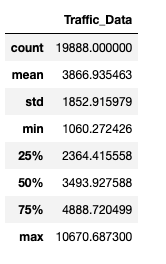

<br>

---


In [ ]:
# 下边的代码都是本文档画图的文档
# 指数特征
x = np.linspace(0,10,100)
y = np.exp(-x)
plt.plot(x,y)
plt.show()

# 绘制 acf 图
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                 index_col=0, 
                 parse_dates=True)
plot_acf(df,adjusted=True).show()